<a href="https://colab.research.google.com/github/pangsoo/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,919 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and dire

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2023-04 다운로드 후 업로드

In [31]:
os.getcwd()

'/content'

In [38]:
!unzip tpss_bcycl_od_statnhm_202304.zip -d tpss_bcycl_od_statnhm_202304.zip

Archive:  tpss_bcycl_od_statnhm_202304.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of tpss_bcycl_od_statnhm_202304.zip or
        tpss_bcycl_od_statnhm_202304.zip.zip, and cannot find tpss_bcycl_od_statnhm_202304.zip.ZIP, period.


## 12-2 CSV 형태의 데이터 수집

In [42]:
import glob
import pandas as pd
import os

## CSV 파일 목록 가져오기 from /content directory
all_files = glob.glob(os.path.join('/content', "*.csv"))

if not all_files:
    print(f"Error: No CSV files found in directory '/content'.")
else:
    dataframes = []
    for filename in all_files:
        ## CSV file reading and converting to dataframe
        try:
            df = pd.read_csv(filename, encoding='cp949', low_memory=False)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")


    if dataframes:
        ## Concatenate all dataframes
        df = pd.concat(dataframes, axis=0, ignore_index=True)

        ## Display the first 5 rows
        display(df.head(5))
    else:
        print("No dataframes were created from the CSV files.")

Error reading /content/tpss_bcycl_od_statnhm_20230411.csv: Error tokenizing data. C error: EOF inside string starting at row 22208
Error reading /content/tpss_bcycl_od_statnhm_20230424.csv: Error tokenizing data. C error: EOF inside string starting at row 121115
Error reading /content/tpss_bcycl_od_statnhm_20230405.csv: 'cp949' codec can't decode byte 0xb5 in position 0: incomplete multibyte sequence
Error reading /content/tpss_bcycl_od_statnhm_20230409.csv: Error tokenizing data. C error: EOF inside string starting at row 22275
Error reading /content/tpss_bcycl_od_statnhm_20230406.csv: Error tokenizing data. C error: EOF inside string starting at row 22170
Error reading /content/tpss_bcycl_od_statnhm_20230423.csv: Error tokenizing data. C error: EOF inside string starting at row 209066
Error reading /content/tpss_bcycl_od_statnhm_20230413.csv: Error tokenizing data. C error: EOF inside string starting at row 22015
Error reading /content/tpss_bcycl_od_statnhm_20230425.csv: Error tokeni

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20230428,출발시간,0.0,ST-1222,구로5동_003_1,ST-1222,구로5동_003_1,1.0,0.0,0.0
1,20230428,출발시간,0.0,ST-182,종로1·2·3·4가동_005_3,ST-182,종로1·2·3·4가동_005_3,1.0,0.0,0.0
2,20230428,출발시간,0.0,ST-2498,휘경1동_007_3,ST-2498,휘경1동_007_3,1.0,1.0,0.0
3,20230428,출발시간,0.0,ST-285,문래동_057_1,ST-285,문래동_057_1,1.0,0.0,0.0
4,20230428,출발시간,0.0,ST-2878,가락2동_056_1,ST-2878,가락2동_056_1,1.0,0.0,0.0


## 12-3 기초 통계량 산출

In [50]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       |        기준_날짜 |   기준_시간대 |     전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|-----------------:|--------------:|--------------:|---------------:|-----------------:|
| count | 599614           |    599614     | 599614        |    599614      |        599614    |
| mean  |      2.02304e+07 |      1376.21  |      1.0512   |        19.2206 |          2176.13 |
| std   |      2.9094      |       577.935 |      0.247302 |        21.3168 |          1859.85 |
| min   |      2.02304e+07 |         0     |      1        |         2      |            11    |
| 25%   |      2.02304e+07 |       910     |      1        |         6      |           918    |
| 50%   |      2.02304e+07 |      1510     |      1        |        12      |          1550    |
| 75%   |      2.02304e+07 |      1825     |      1        |        23      |          2741.75 |
| max   |      2.02304e+07 |      2355     |     13        |       179      |          9999    |

범주형 데이터 요약 통계:
 |        | 집계_기준   | 

## 12-4 결측치 및 이상치 제거

In [49]:
## 결측치 제거
df = df.dropna()
## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
df = df[(df['전체_이용_분'] > 1) & (df['전체_이용_분'] < 180)]
## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
df = df[(df['전체_이용_거리'] > 10) & (df['전체_이용_거리'] < 10000)]
## '집계_기준' 컬럼 필터링 (출발시간만 사용)
df = df[df['집계_기준'] == '출발시간']

## 12-5 날짜/시간 데이터 형식 변환

In [53]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
df['기준_날짜'] = pd.to_datetime(df['기준_날짜'], format='%Y%m%d')
## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}
df['요일'] = df['기준_날짜'].dt.day_name().map(day_mapping)

In [55]:
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일
2127,2023-04-28,출발시간,1545.0,ST-403,청량리동_010_1,ST-403,청량리동_010_1,2.0,2.0,170.0,금요일
3024,2023-04-28,출발시간,1825.0,ST-1977,문래동_047_1,ST-1977,문래동_047_1,2.0,2.0,320.0,금요일
3406,2023-04-28,출발시간,1945.0,ST-1964,신도림동_028_1,ST-1964,신도림동_028_1,2.0,2.0,70.0,금요일
7926,2023-04-28,출발시간,0.0,ST-1011,신월1동_012_1,ST-829,화곡1동_002_1,1.0,4.0,970.0,금요일
7927,2023-04-28,출발시간,0.0,ST-1017,목5동_059_1,ST-2760,신정2동_006_1,1.0,13.0,1910.0,금요일


## 전처리 결과 확인

In [54]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       | 기준_날짜                     |   기준_시간대 |     전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|:------------------------------|--------------:|--------------:|---------------:|-----------------:|
| count | 599614                        |    599614     | 599614        |    599614      |        599614    |
| mean  | 2023-04-27 02:30:32.162691328 |      1376.21  |      1.0512   |        19.2206 |          2176.13 |
| min   | 2023-04-12 00:00:00           |         0     |      1        |         2      |            11    |
| 25%   | 2023-04-26 00:00:00           |       910     |      1        |         6      |           918    |
| 50%   | 2023-04-27 00:00:00           |      1510     |      1        |        12      |          1550    |
| 75%   | 2023-04-28 00:00:00           |      1825     |      1        |        23      |          2741.75 |
| max   | 2023-04-30 00:00:00           |      2355     |     13        |       179      |          9999    |
| std   | nan     

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [56]:
## 요일별 이용량 계산 및 정렬
day_df = df['요일'].value_counts().reindex(day_mapping.values())
## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

요일별 이용량:
 요일
월요일         NaN
화요일         NaN
수요일    151395.0
목요일    167597.0
금요일    146278.0
토요일     43773.0
일요일     90571.0
Name: count, dtype: float64


## 12-7 요일별 이용량 시각화

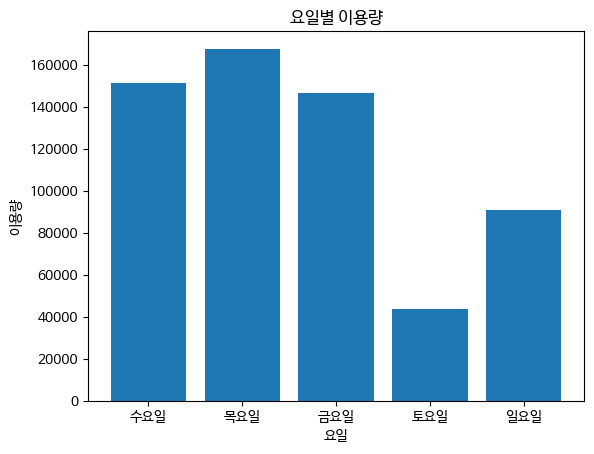

In [58]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.bar(day_df.index, day_df.values)
plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

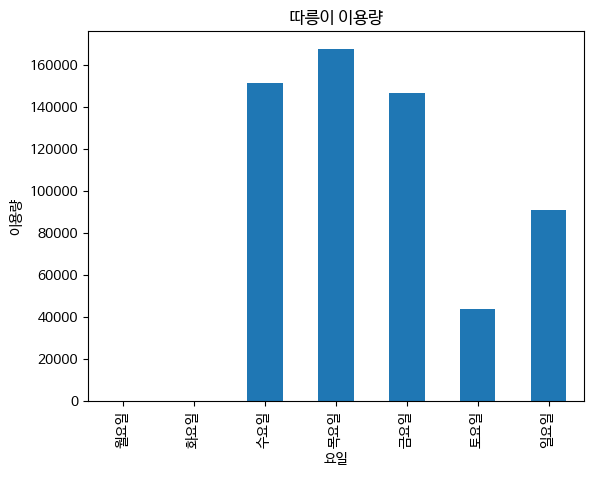

In [65]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
day_df.plot(kind='bar')
plt.title("따릉이 이용량")
plt.xlabel("요일")
plt.ylabel("이용량")
plt.show()

## 12-8 시간별 이용량 분석 및 시각화

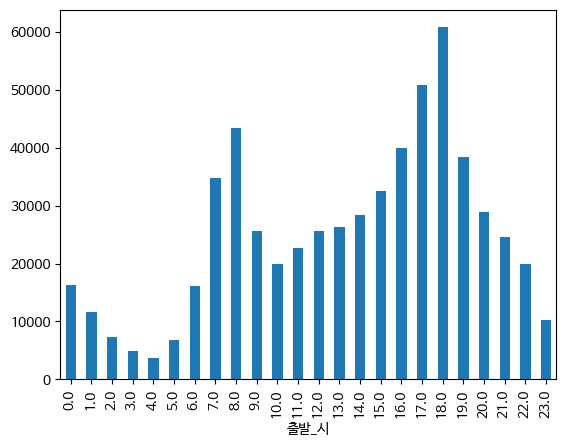

In [67]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100)
df['출발_시'] = df['기준_시간대'] // 100
## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df = df['출발_시'].value_counts().sort_index()
## 시간별 이용량 출력
#print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
2023-04-12     13920
2023-04-20     13797
2023-04-26    137475
2023-04-27    153800
2023-04-28    146278
2023-04-29     43773
2023-04-30     90571
Name: count, dtype: int64


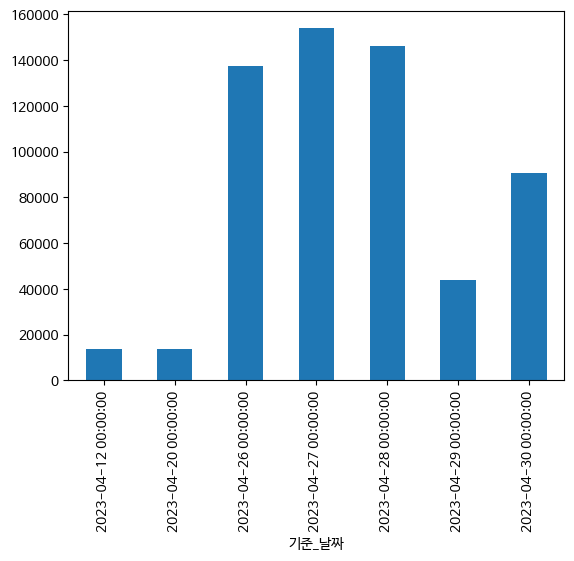

In [68]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2023_04.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [70]:
## 강수량 데이터 CSV 파일 로드
file_path = 'seoul_rain_2023_04.csv'
rain_df = pd.read_csv(file_path, encoding='cp949', skiprows=12)
rain_df.head(5)

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,\t지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각,Unnamed: 6
0,108,서울,2023-04-01,NaN,NaN,NaN,NaN
1,108,서울,2023-04-02,NaN,NaN,NaN,NaN
2,108,서울,2023-04-03,NaN,NaN,NaN,NaN
3,108,서울,2023-04-04,6.9,3.1,21:38,NaN
4,108,서울,2023-04-05,50.3,9.0,12:10,NaN


## 12-11 강수량 데이터 전처리

In [71]:
## '일시' 컬럼 datetime 형식으로 변환
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')
## '강수량(mm)' 컬럼 결측치 0으로 채우기
rain_df['강수량(mm)'] = rain_df['강수량(mm)'].fillna(0)
## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed: 6'], inplace=True)

In [73]:
rain_df.head(5)

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,서울,2023-04-01,0.0,NaN,NaN
1,서울,2023-04-02,0.0,NaN,NaN
2,서울,2023-04-03,0.0,NaN,NaN
3,서울,2023-04-04,6.9,3.1,21:38
4,서울,2023-04-05,50.3,9.0,12:10


## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [90]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_gf의 기준_날짜, rain_df의 일시를 기준으로 결합)
merged_df = pd.merge(daily_usage_df, rain_df, right_on = '일시', left_on='기준_날짜', how='left')

## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,이용량,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,13920,서울,2023-04-12,0.0,NaN,NaN
1,13797,서울,2023-04-20,0.5,0.5,03:59
2,137475,서울,2023-04-26,0.0,0.0,NaN
3,153800,서울,2023-04-27,0.0,NaN,NaN
4,146278,서울,2023-04-28,1.9,1.7,22:51


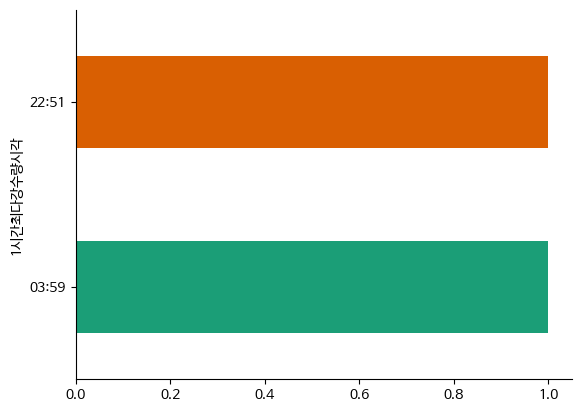

In [83]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('1시간최다강수량시각').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 12-13 이용량 및 강수량 시각화

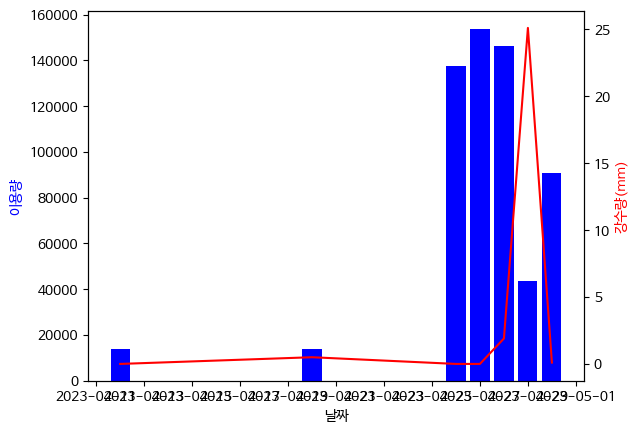

In [93]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기
ax1.bar(merged_df['일시'], merged_df['이용량'], color = 'b')
## 두 번째 y축에 강수량 꺾은선 그래프 그리기
ax2.plot(merged_df['일시'], merged_df['강수량(mm)'], color = 'r')

## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='b')
ax2.set_ylabel('강수량(mm)', color='r')

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

강수량과 이용량의 상관계수: -0.3028552944814711


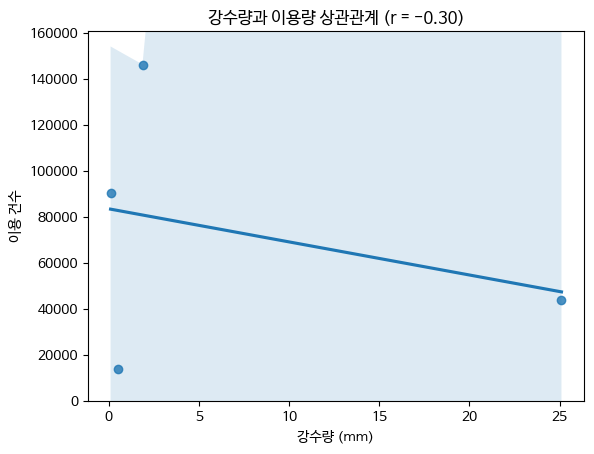

In [95]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]
## 강수량과 이용량의 상관계수 계산
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성
ax = sns.regplot(x = '강수량(mm)', y = '이용량',
                 data = merged_onlyrain_df)

## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [97]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True)

## OLS 모델 정의 및 학습
model = smf.ols(formula='이용량 ~ 강수량_mm', data = merged_onlyrain_df)
results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석
print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")

                            OLS Regression Results                            
Dep. Variable:                    이용량   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                 -0.362
Method:                 Least Squares   F-statistic:                    0.2020
Date:                Wed, 15 Oct 2025   Prob (F-statistic):              0.697
Time:                        15:08:31   Log-Likelihood:                -48.770
No. Observations:                   4   AIC:                             101.5
Df Residuals:                       2   BIC:                             100.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.355e+04   4.04e+04      2.070      0.1

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
